# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [11]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [7]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
Downloaded ner, extracting to ../stanford-NLP/ner
Downloaded parser, extracting to ../stanford-NLP/parser
Downloaded core, extracting to ../stanford-NLP/core
Downloaded postagger, extracting to ../stanford-NLP/postagger
Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [9]:
import lucem_illud.stanford as stanford

Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [12]:
text = ['I saw the elephant in my pajamas.', 
        'The quick brown fox jumped over the lazy dog.', 
        'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 
        'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 
        'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [6]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [7]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [8]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [9]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [10]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [11]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 (')', 14),
 ('time', 14),
 ('computer', 12),
 ('lot', 12),
 ('email', 11),
 ('life', 11),
 ('**Genius**', 10),
 ('message', 9),
 ('**Me**', 9),
 ('system', 9),
 ('day', 9),
 ('story', 8),
 ('laptop', 8),
 ('call', 8),
 ('today', 8),
 ('part', 8),
 ('office', 8),
 ('problem', 7)]

What about the number of top verbs (`VB`)?

In [12]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('help', 6),
 ('look', 6),
 ('send', 6),
 ('tell', 6),
 ('go', 5),
 ('feel', 4),
 ('take', 4),
 ('call', 4),
 ('receive', 4),
 ('thank', 4),
 ('work', 4),
 ('see', 4)]

What about the adjectives that modify the word, "computer"?

In [13]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [14]:
#Chinese tree bank
ctb= nltk.corpus.sinica_treebank

In [15]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [16]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [17]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [18]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

<span style="color:green"> I gathered some random text for this exercise. I watched some HPV commercials on youtube and I found that have very different advertising styles. I transcribed the 9 short videos. 

<span style="color:green"> I watched these videos and I know the differences between them. This is a toy dataset for practicsing the codes. I do not get much new information from identifying noun and verb. 

<span style="color:green"> Even though the vaccine is for both boys and girls, the commercial still have a focus on girls. The commercials also speak to mothers more. No adjective is included in these commercial. The commercial probably try to keep themselve more factual. 

In [4]:
hpv0= "Each year in the US, thousands of women learn they have cervical cancer. I could be one less. One less statistic. One less because now there’s Gardasil, the only vaccine that may help protect you from four types of human papillomavirus that may cause seventy percent of cervical cancer. I want to be one less women who battle cervical cancer. One less. Like all vaccines, Gardasil may not fully protect everyone. The side effects include pain, swelling, itching and redness at the injection site, fever, nausea, or dizziness. Gardasil is not for women who are pregnant. Gardasil does not prevent all types of cervical cancer. So it is important to continue with routine cervical cancer screening. Gardasil will not treat cervical cancer. Ask your doctor about getting back saved with the only cervical cancer vaccine. Gardasil, Gardasil, Gardasil. With Gardasil you could be one less. I want to be one less, one less."
hpv1= "I chose to get vaccinated because I will do everything I can to help protect myself from cervical cancer. I chose to get vaccinated when my doctor told me HPV can affect women my age and how Gardasil can help protect me. Gardasil is the only cervical cancer vaccine that helps protect against four types of HPV. Two types that cause seventy percent of cervical cancer and two more types that causes other HPV diseases. I chose to get vaccinated after my doctor told me cervical cancer isn’t the only HPV disease Gardasil helps prevent. Gardasil does not treat cervical cancer or other HPV diseases. Side effects include pain, swelling, itching and redness at the injection site, fever, nausea, dizziness, vomiting and fainting. Gardasil is not for women who are pregnant. Gardasil may not fully protect everyone and does not prevent all kinds of cervical cancer so it is important to continue routine cervical cancer screenings. I chose to get vaccinated because my dreams don’t include cervical cancer. Gardasil, Gardasil, Gardasil. You have the power to choose. Ask your doctor about Gardasil."
hpv2= "I have cervical cancer from an infection of human papillomavirus. Who knew HPV could lead to certain cancers? Who knew my risk for HPV would increase as I got older? Who knew that there is something that could have helped protect me from HPV when I was 11 or 12, way before I would even be exposed to it. Did you know, mom, dad?  Who knew HPV could cause certain cancers and diseases in girls? And boys. I was infected with HPV. maybe my parents didn’t know how widespread HPV is while HPV clears up for most that wasn’t the case for me. Maybe they didn’t know I would end up with cancer because of HPV. Maybe if they had known there was a vaccine to help protect me when I was 11 or 12 maybe my parents just didn't know. Right, mom, dad? What will you say? Don't wait talk to child’s doctor today. Learn more at HPV.com."
hpv3= "If I had taken action to prevent HPV, my daughter wouldn’t be infected by the virus. HPV can infect baby via the birth canal of mother. Winnie is now admitted to hospital for her fourth laryngeal surgery. Mom, I want to go home now. If you don’t want your loved ones to be affected, take action to prevent HPV virus now."
hpv4= "In Hong Kong, more than 400 women are diagnosed with cervical cancer every year in average. Nine types of HPV can cause ninety percent of cervical cancers. Do not hesitate, take action to prevent HPV virus now."
hpv5= "I am Sarah; I am sixteen. My name is Robin; I am fourteen. I am Song; I am twenty. My name is Lucy; I am eighteen. Cervical cancer affects the neck of the women. It is the second most common cancer between the age of twenty-five and thirty-nine. My name is Rosina; I am twenty-five years old. My name is Ketie; I am nineteen. I am Lowise; I am twenty-one. I am Dara; I am fifteen years old. Three hundred women will develop cervical cancer, and ninety women unfortunately will die from cervical cancer every year. My mom has got cervical cancer so I am at a really high risk. All mothers want what’s best for their children and HPV vaccination is one way of preventing cervical cancer. I got the information from Alicia at my school. You learned what the HPV vaccine was what do we feel like to get it and that it lowers the risk of cervical cancer. There is a wealthy of reputable information on the HSE website that can help you and your family make an informed decision regarding HPV vaccination. I got the HPV vaccine, I got the HPV vaccine; I got the HPV vaccine; I got the HPV vaccine; I got the HPV vaccine. There is excellent scientific evidence that shows that HPV vaccination prevents cervical cancer. Get the vaccine. Get the vaccine. Get the vaccine. Protect our future."
hpv6= "She won’t always be this carefree. But your choices now can protect her from cancer later. The HPV vaccine can protect her from certain cancers and other diseases caused by HPV. Girls and boys should be vaccinated at eleven or twelve or as soon as possible if they are older. Get the vaccine today and worry less about cancer tomorrow. HPV vaccine is cancer prevention. Talk to your child’s doctor or visit health.ny.gov/HPV."
hpv7= "I can’t protect myself against cervical cancer. Now every year nine girl can thanks to the new HPV vaccine. It can prevent hundreds of deaths from cervical cancer in the UK every year. The HPV vaccine is now being offered in states to all year nine girls. So if you are a parent or a girl in year nine and want more information then visit www.helpprotectyourself.info."
hpv8= "Every day about thirty women in the US learned that they have cervical cancer. That’s why I chose to get my daughter vaccinated. I chose to get my daughter vaccinated when her doctor and I agreed that the right time to protect her is now because it’s about prevention. Gardasil is the only cervical cancer vaccine to protect against four types of HPV. Two types cause seventy percent of cervical cancer and two more types that causes other HPV diseases. I chose to get my daughter vaccinated because the CDC recommends that girls her age get vaccinated. Gardasil does not treat cervical cancer or other HPV diseases. Gardasil may not fully protect everyone and does not prevent all kinds of cervical cancer. So it is important to continue routine cervical cancer screening. I chose to get my daughter vaccinated because I want her to be one less women affected by cervical cancer. One less. Guard herself. Ask your daughter’s daughter about Gardasil."


hpvDF= pandas.DataFrame({"ad": [hpv0, hpv1, hpv2, hpv3, hpv4, hpv5, hpv6, hpv7, hpv8], 
                         "loc": ["us", "us", "us", "hk", "hk", "ireland", "us", "uk", "us"]})
hpvDF

,ad,loc
0,"Each year in the US, thousands of women learn ...",us
1,I chose to get vaccinated because I will do ev...,us
2,I have cervical cancer from an infection of hu...,us
3,"If I had taken action to prevent HPV, my daugh...",hk
4,"In Hong Kong, more than 400 women are diagnose...",hk
5,I am Sarah; I am sixteen. My name is Robin; I ...,ireland
6,She won’t always be this carefree. But your ch...,us
7,I can’t protect myself against cervical cancer...,uk
8,Every day about thirty women in the US learned...,us


In [5]:
hpvDF['sentences'] = hpvDF['ad'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
hpvDF['POS_sents'] = hpvDF['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [21]:
hpvDF['POS_sents']

0    [[(Each, DT), (year, NN), (in, IN), (the, DT),...
1    [[(I, PRP), (chose, VBD), (to, TO), (get, VB),...
2    [[(I, PRP), (have, VBP), (cervical, JJ), (canc...
3    [[(If, IN), (I, PRP), (had, VBD), (taken, VBN)...
4    [[(In, IN), (Hong, NNP), (Kong, NNP), (,, ,), ...
5    [[(I, PRP), (am, VBP), (Sarah, NNP), (;, :), (...
6    [[(She, PRP), (won, VBD), (’, CD), (t, NN), (a...
7    [[(I, PRP), (can, MD), (’, VB), (t, NN), (prot...
8    [[(Every, DT), (day, NN), (about, IN), (thirty...
Name: POS_sents, dtype: object

In [22]:
countTarget = 'NN'
targetCounts = {}
for entry in hpvDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
print(sortedTargets[:20])


[('cancer', 38), ('HPV', 22), ('vaccine', 19), ('t', 9), ('daughter', 7), ('year', 7), ('doctor', 7), ('s', 5), ('name', 4), ('percent', 4), ('age', 3), ('mom', 3), ('everyone', 3), ('virus', 3), ('action', 3), ('risk', 3), ('vaccination', 3), ('information', 3), ('dizziness', 2), ('itching', 2)]


In [23]:
countTarget = 'VB'
targetCounts = {}
for entry in hpvDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
print(sortedTargets[:20])


[('protect', 14), ('be', 10), ('get', 10), ('prevent', 8), ('help', 5), ('Get', 4), ('treat', 3), ('cause', 3), ('Ask', 3), ('continue', 3), ('know', 2), ('want', 2), ('take', 2), ('have', 1), ('Protect', 1), ('wait', 1), ('Learn', 1), ('increase', 1), ('worry', 1), ('feel', 1)]


In [24]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in hpvDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

set()


# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [25]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [26]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [27]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [28]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [29]:
[x[0] for x in sortedEntities if x[1] == 2]

['understand',
 'BING',
 'working',
 'seconds',
 'live',
 'um',
 'first',
 'business',
 'bitter',
 'blinked',
 'whose',
 'error',
 'turn',
 '=',
 'holiday',
 '*I',
 'took',
 'certain',
 'course',
 'supervisor',
 "'P4ssword",
 'existence',
 'ok',
 'ask',
 'party',
 'looking',
 'loved',
 'Everything',
 'risks',
 'pay',
 'gildings',
 'generate',
 'drawer*',
 'academic',
 'soon',
 'pages',
 'Steve',
 'avoid',
 'plugged',
 'occasionally',
 'well',
 'person',
 'reply',
 'heard',
 'using',
 '*Are',
 'played',
 'needed',
 'spent',
 'food',
 'mind',
 'shaking',
 'completely',
 'year',
 'case',
 'done',
 'login',
 'often',
 'stuff',
 'stronger',
 'tears',
 'proud',
 'organization',
 'wrong',
 'avalanche',
 'In',
 'revealing',
 'speak',
 'moment',
 'passed',
 'forwarded',
 'lunch',
 'watched',
 'brought',
 'mother',
 'bane',
 'Give',
 'believe',
 'search',
 'cry',
 '#',
 'stopped',
 'Then',
 'asset',
 'Things',
 'mess',
 'bad',
 'store',
 'same',
 'month',
 'happiness',
 'SO',
 'window',
 'four',

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [30]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('Boss', 1),
 ('CMD', 1),
 ('Buzzfeed', 1),
 ('Spotify', 1),
 ('Nono', 1),
 ('Clickity', 1)]

What about the Organizations?

In [31]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('CMD', 1), ('GOOGLE', 1), ('Helpdesk', 1), ('Citrix', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

<span style="color:green"> The commercials target on general public and assumes no backgound information. The code recongize "Gardasil" as an organization. But it is actually a vaccine for HPV. Several human names were identified as non-objects. A couple of videos appear to emotions and invite girls to speak in front of the camera "I am xxx".

In [6]:
hpvDF['classified_sents'] = hpvDF['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [33]:
entityCounts = {}
for entry in hpvDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 93),
 ('I', 44),
 ('cancer', 38),
 ('HPV', 35),
 ('the', 34),
 ('cervical', 33),
 ('to', 32),
 (',', 31),
 ('Gardasil', 23),
 ('of', 21)]

In [34]:
nonObjCounts = {}
for entry in hpvDF['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Gardasil', 23),
 ('US', 2),
 ('Lowise', 1),
 ('Lucy', 1),
 ('Robin', 1),
 ('Rosina', 1),
 ('Sarah', 1),
 ('Ketie', 1),
 ('UK', 1),
 ('Winnie', 1)]

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [35]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [36]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [37]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [38]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [39]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [40]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [41]:
list(parses[1])[0].pretty_print()

                     ROOT                           
                      |                              
                      S                             
       _______________|___________________________   
      |                          VP               | 
      |                __________|___             |  
      |               |              PP           | 
      |               |      ________|___         |  
      NP              |     |            NP       | 
  ____|__________     |     |     _______|____    |  
 DT   JJ    JJ   NN  VBD    IN   DT      JJ   NN  . 
 |    |     |    |    |     |    |       |    |   |  
The quick brown fox jumped over the     lazy dog  . 



## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [42]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x1196492f0>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'word

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

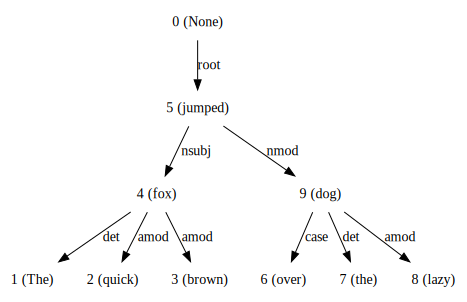

In [43]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

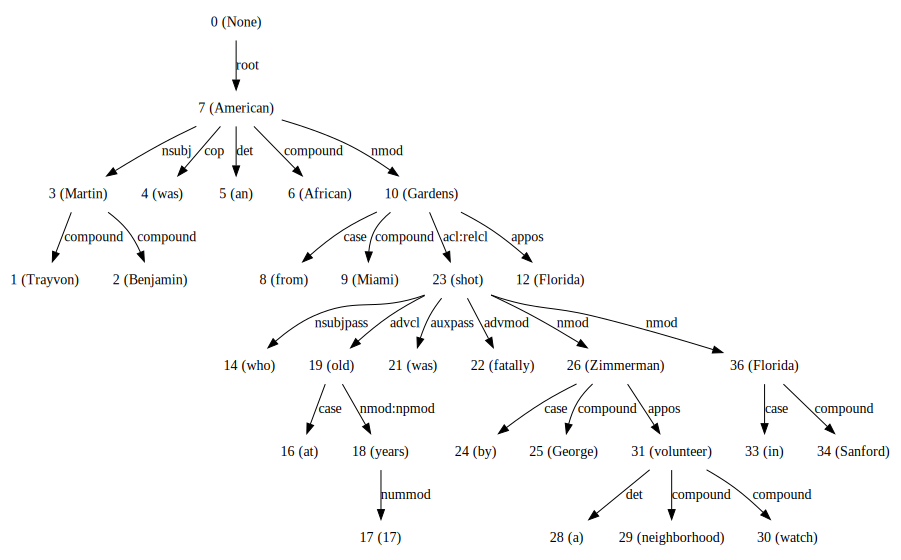

In [44]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [45]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [46]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

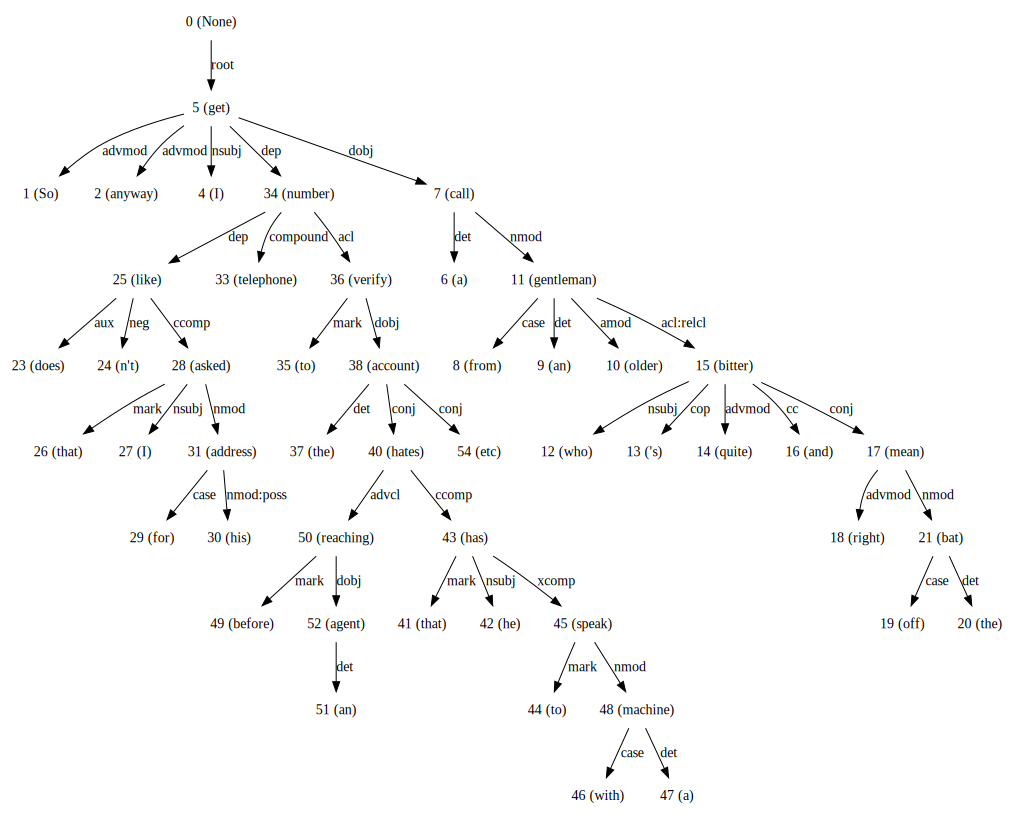

In [34]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

In [144]:
parses = list(stanford.parser.parse_sents(hpvDF["sentences"][2])) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('SBAR', [Tree('WHNP', [Tree('WP', ['Who'])]), Tree('S', [Tree('VP', [Tree('VBD', ['knew']), Tree('SBAR', [Tree('IN', ['that']), Tree('S', [Tree('NP', [Tree('EX', ['there'])]), Tree('VP', [Tree('VBZ', ['is']), Tree('NP', [Tree('NP', [Tree('NN', ['something'])]), Tree('SBAR', [Tree('WHNP', [Tree('WDT', ['that'])]), Tree('S', [Tree('VP', [Tree('MD', ['could']), Tree('VP', [Tree('VB', ['have']), Tree('VP', [Tree('VBN', ['helped']), Tree('S', [Tree('VP', [Tree('VB', ['protect']), Tree('NP', [Tree('PRP', ['me'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NNP', ['HPV'])])])])]), Tree('SBAR', [Tree('WHADVP', [Tree('WRB', ['when'])]), Tree('S', [Tree('NP', [Tree('PRP', ['I'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('QP', [Tree('CD', ['11']), Tree('CC', ['or']), Tree('CD', ['12'])])]), Tree(',', [',']), Tree('ADVP', [Tree('NN', ['way']), Tree('IN', ['before'])])])])])])])])])])])])])])])])]), Tree('NP', [Tree('PRP', ['I'])]), Tree('VP', [T

In [163]:
treeRelation(fourthSentParseTree, 'VP', 'protect')

[[('VP',
   'knew that there is something that could have helped protect me from HPV when I was 11 or 12 , way before')],
 [('VP',
   'is something that could have helped protect me from HPV when I was 11 or 12 , way before')],
 [('VP',
   'could have helped protect me from HPV when I was 11 or 12 , way before')],
 [('VP', 'have helped protect me from HPV when I was 11 or 12 , way before')],
 [('VP', 'helped protect me from HPV when I was 11 or 12 , way before')],
 [('VP', 'protect me from HPV')]]

In [164]:
fourthSentParseTree[0].pretty_print()

                                                                                          ROOT                                                                                    
                                                                                           |                                                                                       
                                                                                           S                                                                                      
       ____________________________________________________________________________________|____________________________________________________________________________________   
     SBAR                                                                                                                            |              |                           | 
  ____|____                                                                                            

In [8]:
hpv_text= []
for s in hpvDF["sentences"][2]:
    hpv_text+= [" ".join(s)]

In [175]:
depParses = list(stanford.depParser.raw_parse_sents(hpv_text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[3])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x119c02488>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [28]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'WP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 2,
                 'lemma': '_',
                 'rel': 'nsubj',
                 'tag': 'WP',
                 'word': 'Who'},
             2: {'address': 2,
                 'ctag': 'VBD',
                 'deps': defaultdict(<class 'list'>,
                                     {'ccomp': [5],
                                      'nsubj': [1]}),
                 'feats': '_',
                 'head': 28,
         

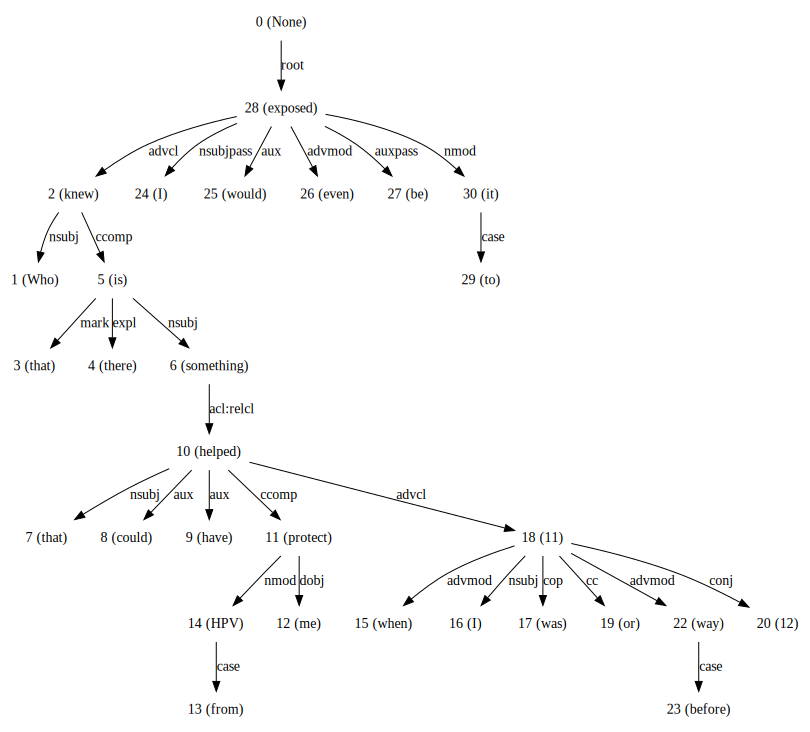

In [176]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [13]:
ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 13.06 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [14.6 sec].
[main] INFO edu.stanford.nlp.pipe

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [14]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

In [18]:
ieDF[ieDF['subject'] == 'Trayvon Benjamin Martin']['verb']

25    was African American from
26            was American from
27                          was
28                          was
Name: verb, dtype: object

In [20]:
ieDF[ieDF['subject'] == 'Trayvon Benjamin Martin']['object']

25             Florida
26             Florida
27            American
28    African American
Name: object, dtype: object

<span style="color:green"> This operation is useful on the one hand but also limited on the other. I need to put in exact words to search for the corresponding objects and verbs. For example, if I search "Trayvon Martin" rather than "Trayvon Benjamin Martin", then I cannot find anything. This method is only useful for very specific tasks with a clearn goal.

### Information Extraction Continues

And we can also look for subject, object, target triples in one of the reddit stories.

In [49]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.3 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 17.87 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [19.5 sec].
[main] INFO edu.stanford.nlp.pipe

In [50]:
ieDF

,certainty,subject,verb,object
0,1.000000,we,'ll get,calls
1,1.000000,we,Quite often 'll get,calls
2,1.000000,we,often 'll get,calls
3,0.831036,we,coax,direct to TV
4,0.774359,straight analog cable,coax,direct from wall
5,0.774359,analog cable,coax,direct from wall to TV
6,0.774359,straight analog cable,coax,direct to TV
7,1.000000,we,would supply analog cable to,homes
8,0.831036,we,coax,direct from wall
9,0.774359,analog cable,coax,direct from wall


That's almost 200 triples in only:

In [54]:
len(redditTopScores['sentences'][0])

37

sentences and

In [55]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [56]:
ieDF['subject'].value_counts()

I                        48
it                       42
he                       19
He                       18
we                       11
old man                   8
man                       8
analog cable              4
our booking calendar      4
letter                    4
straight analog cable     4
call                      4
my supervisor             3
his TV set                2
TV                        2
you                       2
they                      2
repeat offenders          1
me                        1
our digital equipment     1
handling                  1
people                    1
our equipment             1
Name: subject, dtype: int64

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [57]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

could come                        8
brought                           5
even brought                      5
was                               4
had                               4
speak for                         3
speak with                        1
had cable within                  1
do                                1
felt                              1
get to                            1
have                              1
So anyway get                     1
anyway get                        1
still think occasionally about    1
've dealt with                    1
think about                       1
think occasionally about          1
ask                               1
took                              1
get                               1
instantly felt                    1
still think about                 1
complaint in                      1
eventually had                    1
Name: verb, dtype: int64

and the following objects

In [58]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Mr. Smith                                             4
call                                                  3
him                                                   3
simplified remote                                     2
remote                                                2
simplified remote for his set top box                 2
willing                                               2
this                                                  2
remote for his set top box                            2
bad                                                   2
get                                                   2
speak for bit about account                           1
useless                                               1
her                                                   1
speak with her for bit                                1
bit about account for Mr. Smith                       1
cable                                                 1
book                                            

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [140]:
stanford.startCoreServer()

Starting server on http://localhost:16432 , please wait a few seconds

Exiting (ノ≧▽≦)ノ


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.

<span style="color:green"> I sum up the text of the 9 commercials into one long text, which is then used as the input for the SAO analysis. 

<span style="color:green"> "Side effects" as the subject correspond to "pain at injection site", "itching", "pain", "swelling", and "redness". 

In [35]:
all_text= ""
for ad in hpvDF["ad"]:
    all_text+= ad.lower()

In [36]:
ieDF = stanford.openIE(all_text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 15.641 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [17.5 sec].
[main] INFO edu.stanford.nlp.pip

In [37]:
ieDF

,certainty,subject,verb,object
0,1.000000,they,have,cancer
1,1.000000,they,have,cervical cancer
2,1.000000,effects,include,swelling
3,1.000000,side effects,include,pain
4,0.311903,redness,pain at,injection site
5,1.000000,effects,include,redness
6,1.000000,side effects,include,redness
7,1.000000,effects,include,pain at injection site
8,1.000000,effects,include,itching
9,1.000000,side effects,include,pain at injection site


In [38]:
ieDF['subject'].value_counts()

i                      44
it                     24
winnie                 12
gardasil               12
side effects           10
effects                10
you                     9
her                     8
who knew                6
my mom                  5
they                    5
women                   4
cervical cancer         4
your choices            4
two types               3
types                   3
cancer                  3
hpv                     3
nine girl               2
three hundred women     2
hpv vaccination         2
information             2
more information        2
vaccine                 2
redness                 2
girl                    2
hpv vaccine             2
best                    2
girls                   2
your family             2
ninety women            2
decision                1
parent                  1
cancers                 1
cdc                     1
my daughter             1
other diseases          1
child                   1
thirty women

In [40]:
ieDF[ieDF['subject'] == 'side effects']['object'].value_counts()

pain at injection site    2
itching                   2
pain                      2
swelling                  2
redness                   2
Name: object, dtype: int64